# 4. Training Models - Linear Regression

We'll be looking at the Linear Regression Model and specifically two ways of arriving at the solution:
* Using a direct "closed-form" equation
* Using an iterative optimization approach called Gradient Descent that gradually tweaks the model parameters to minimize the cost function over the training set eventually converging to the same set of parameters as the first method

## Linear Regression

$\hat{y} = \theta_0 + \theta_1x_1 + \theta_2x_2 + ... + + \theta_nx_n$

Where:
* $\hat{y}$ is the predicted value
* n is the number of features
* $x_i$ is the i<sup>th</sup> feature value
* $\theta_j$ is the j<sup>th</sup> model parameter

This can be written in a vectorised form as:<br>
$\hat{y} = h_\theta(x) =\theta.x$

We need to minimize the Mean Square Error which is given as:

$MSE(X,h_\theta) = \frac{1}{m}\sum_{i=1}^{n}(\theta^T x^{i} - y^{i})^2$

## The Normal Equation

Instead of minimizing, we can simply find a solution to theta:

$\hat{\theta} = (X^TX)^{-1}X^Ty$

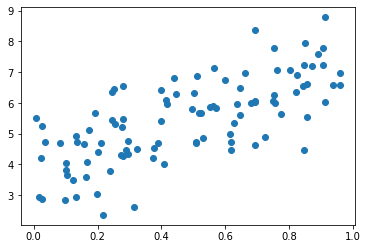

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

X = np.random.rand(100, 1)

# Gaussian noise
y = 4 + 3 * X + np.random.randn(100, 1)

plt.scatter(X, y)

In [2]:
X_b = np.c_[np.ones(shape = X.shape), X]
theta = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)
theta

array([[3.83807703],
       [3.39059135]])

And we can see that we've come pretty close to the excepted values of 4 and 3. We haven't reached the precise values because of the Gaussian noise that we threw in.

We can now make predictions using these values. For example:

In [3]:
y_predict = X_b.dot(theta)

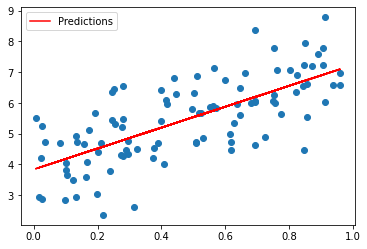

In [4]:
plt.plot(X, y_predict, 'r-')
plt.scatter(X, y)
plt.legend(['Predictions'])
plt.show()

Performing Linear Regression using Scikit-Learn is simple

In [5]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X, y)
lin_reg.intercept_, lin_reg.coef_

(array([3.83807703]), array([[3.39059135]]))

`LinearRegression` class is based on the `scipy.linalg.lstsq()` function which you could call directly

In [6]:
theta_best_svd, residuals, rank, s = np.linalg.lstsq(X_b, y, rcond = 1e-6)
theta_best_svd

array([[3.83807703],
       [3.39059135]])

Alternatively, we can calculate the pseudoinverse of X and then the formula for $\theta$ becomes:

$\hat{\theta} = X_b^+y$

In [7]:
np.linalg.pinv(X_b).dot(y)

array([[3.83807703],
       [3.39059135]])

## Computational Complexity

The computational complexity of inverting a matrix is ~$O(n^3)$. Thus on doubling the number of features, we raise the computation time by about 8 times. 
On the other hand, the SVD approach used by Scikit-Learn's LinearRegression class is ~$O(n^2)$. If you double the number of features, you multiply the computation time by roughly 4.

## Gradient Descent

To implement Gradient Descent, we need to compute the gradient of the cost function with regard to each model parameter $\theta_j$

$\frac{\delta MSE(\theta)}{\delta\theta_j} = \frac{2}{m}\sum_{i=1}^m(\theta^Tx^i - y^i)x_j^i$

$\Delta MSE(\theta) = \frac{2}{m}X^T(X\theta - y)$

**Gradient Descent step**

$\theta^{next step} = \theta - \alpha\Delta MSE(\theta)$

In [8]:
alpha = 0.1
n_iterations = 100
m = X.shape[0]

# randomly initialise theta
theta = np.random.rand(2,1)

for i in range(n_iterations):
    delta = (2/m)*X_b.T.dot((X_b.dot(theta) - y))
    theta = theta - (alpha * delta)

theta

array([[3.93540113],
       [3.19903138]])

## Stochastic Gradient Descent

The main problem with Batch Gradient Descent is the fact that it uses the whole training set to compute the gradients at every step, which makes it very slow when the training set is large. At the opposite extreme, Stochastic Gradient Descent picks a random instance in the training set at every step and computes the gradients based only on that single instance. Obviously, working on a single instance at a time makes
the algorithm much faster because it has very little data to manipulate at every iteration. It also makes it possible to train on huge training sets, since only one instance needs to be in memory at each iteration.

In [9]:
n_epochs = 50
t0, t1 = 5, 50 # learning schedule hyperparameters

def learning_schedule(t):
    return t0 / (t + t1)

theta = np.random.randn(2,1) # random initialization
for epoch in range(n_epochs):
    for i in range(m):
        random_index = np.random.randint(m)
        xi = X_b[random_index:random_index+1]
        yi = y[random_index:random_index+1]
        gradients = 2 * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(epoch * m + i)
        theta = theta - eta * gradients

theta

array([[3.80610123],
       [3.3834931 ]])

We can add regularisation using:

In [10]:
from sklearn.linear_model import Ridge
ridge_reg = Ridge(alpha=1, solver="cholesky")
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([[8.53078654]])

In [11]:
from sklearn.linear_model import SGDRegressor

sgd_reg = SGDRegressor(penalty="l2")
sgd_reg.fit(X, y.ravel())
sgd_reg.predict([[1.5]])

array([8.03905118])

In [12]:
from sklearn.linear_model import Lasso
lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(X, y)
lasso_reg.predict([[1.5]])

# You can also use SGDRegressor(penalty="l1")

array([7.6162577])

Elastic Net is a middle ground between Ridge Regression and Lasso Regression.

$J(\theta) = MSE(\theta) + r\alpha\sum_{i=1}^n|\theta_j| + \frac{1-r}{2}\alpha\sum_{i=1}^n\theta_j^2$

In [13]:
from sklearn.linear_model import ElasticNet
elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5)
elastic_net.fit(X, y)
elastic_net.predict([[1.5]])

array([7.17192003])

## Early Stopping

In order to prevent diverging away from the minima and/or overfitting we might consider stopping training early. The following code segment achieves this.

In [23]:
from sklearn.base import clone
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

y = y.reshape(y.shape[0],)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state = 42)

poly_scaler = Pipeline([
    ('poly_features',PolynomialFeatures(degree=90, include_bias = False)),
    ('std_scaler',StandardScaler())
])

X_train_poly_scaled = poly_scaler.fit_transform(X_train)
X_val_poly_scaled = poly_scaler.transform(X_val)
sgd_reg = SGDRegressor(max_iter=1, tol=-np.infty, warm_start=True, penalty=None, learning_rate="constant", eta0=0.0005)
minimum_val_error = float("inf")
best_epoch = None
best_model = None
for epoch in range(1000):
    sgd_reg.fit(X_train_poly_scaled, y_train) # continues where it left off
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    val_error = mean_squared_error(y_val, y_val_predict)
    if val_error < minimum_val_error:
        minimum_val_error = val_error
    best_epoch = epoch
    best_model = clone(sgd_reg)